In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize, poly, sklearn_sm, Stepwise, sklearn_selected, sklearn_selection_path)
from functools import partial
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm

In [6]:
import pygam as pg
from ISLP.transforms import BSpline, NaturalSpline
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam, degrees_of_freedom, plot as plot_gam, anova as anova_gam)

In [7]:
wage = load_data('Wage')
y = wage['wage']
age = wage['age']

In [12]:
poly_age = MS([poly('age', degree=4)]).fit(wage)
M = sm.OLS(y, poly_age.transform(wage)).fit()
summarize(M)

c:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


In [13]:
M.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     70.69
Date:                Fri, 21 Feb 2025   Prob (F-statistic):           2.77e-57
Time:                        16:04:07   Log-Likelihood:                -15315.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2995   BIC:                         3.067e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
intercept                111.7036      0.729    153.283      0.000     110.275     113.132
poly(age, degree=4)[0]   447.0679     39.915     11.201      0.000     368.805     525.331
poly(age, degree=4)[1]  -478.3158     39.915    -11.983      0.000    -556.579    -400.053
poly(age, degree=4)[2]   125.5217     39.915      3.145      0.002      47.259     203.785
poly(age, degree=4)[3]   -77.9112     39.915     -1.952      0.051    -156.174       0.352
==============================================================================
Omnibus:                     1097.594   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4965.521
Skew:                           1.722   Prob(JB):                         0.00
Kurtosis:                       8.279   Cond. No.                         54.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
age_grid = np.linspace(age.min(), age.max(), 100)
age_df = pd.DataFrame({'age':age_grid})
age_df

,age
0,18.000000
1,18.626263
2,19.252525
3,19.878788
4,20.505051
...,...
95,77.494949
96,78.121212
97,78.747475
98,79.373737


In [17]:
def plot_wage_fit(data, y, pred_data, basis, title):
    X = basis.transform(data)
    X_new = basis.transform(pred_data)
    M = sm.OLS(y, X).fit()
    preds = M.get_prediction(X_new)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.scatter(data['age'], y, facecolor='gray', alpha=0.5)
    for val, ls in zip([preds.predicted_mean, bands[:, 0], bands[:, 1]], ['b', 'r--', 'r--']):
        ax.plot(pred_data.values, val, ls, linewidth=3)
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('Age')
    ax.set_ylabel('Wage')
    return ax

<AxesSubplot:title={'center':'Degree-4 Polynomial'}, xlabel='Age', ylabel='Wage'>

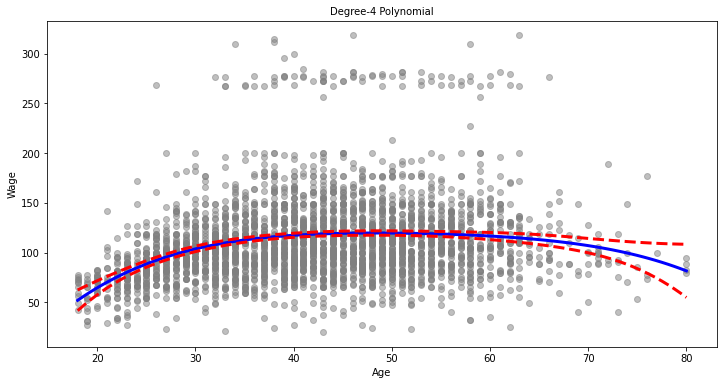

In [18]:
plot_wage_fit(wage, y, age_df, poly_age, 'Degree-4 Polynomial')

In [20]:
models = [MS([poly('age', degree=d)]) for d in range(1, 6)]
Xs = [model.fit_transform(wage) for model in models]
anova_lm(*[sm.OLS(y, X_).fit() for X_ in Xs])

c:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01
